# Recommendations for Potential Folk/Country Artists to Achieve Top Ratings on Pitchfork

Our statistical analysis is centered on the question, what can a potential folk/country artist do to achive top ratings and get best new music on Pitchfork? To answer this question, we did some exploratory data analysis and conducted the the following hypotheses. 
* Is there a statistical difference between the scores of folk/country and metal genres?
* Is there a difference between the scores of folk/country and all other music genres?
* Is there a difference between the average of best new music awards for each label?
* Is there a difference between the average scores given by each author for folk/country music?
* Is there a difference between the average scores of folk country music for each label?

Below is the entity relationship diagram for our database.

## Setting Up Database and Importing Libraries

In [299]:
import pandas as pd
import sys
import numpy as np
import sklearn as sk
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mstats
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

%matplotlib inline

In [2]:
# Create a connection to the database
conn = psycopg2.connect("dbname=pitchfork")

In [3]:
cur = conn.cursor()

## Exploratory Data Analysis

To orient, conduct exploratory queries. Look at table names, columns, and visualize in dataframes.

In [4]:
query_tables_and_columns = """ SELECT table_name, column_name
FROM information_schema.columns
WHERE table_schema= 'public'
ORDER BY table_name, column_name;"""

In [5]:
cur.execute(query_tables_and_columns)

In [6]:
cur.fetchall()

[('artists', 'artist'),
 ('artists', 'id'),
 ('artists', 'reviewid'),
 ('content', 'content'),
 ('content', 'id'),
 ('content', 'reviewid'),
 ('genres', 'genre'),
 ('genres', 'id'),
 ('genres', 'reviewid'),
 ('labels', 'id'),
 ('labels', 'label'),
 ('labels', 'reviewid'),
 ('reviews', 'artist'),
 ('reviews', 'author'),
 ('reviews', 'author_type'),
 ('reviews', 'best_new_music'),
 ('reviews', 'id'),
 ('reviews', 'pub_date'),
 ('reviews', 'pub_day'),
 ('reviews', 'pub_month'),
 ('reviews', 'pub_weekday'),
 ('reviews', 'pub_year'),
 ('reviews', 'reviewid'),
 ('reviews', 'score'),
 ('reviews', 'title'),
 ('reviews', 'url'),
 ('years', 'id'),
 ('years', 'reviewid'),
 ('years', 'year')]

In [7]:
# Create artists dataframe
df_artists = psql.read_sql("SELECT * FROM artists;", conn)
df_artists.head()

,reviewid,artist,id
0,22703,massive attack,1
1,22721,krallice,2
2,22659,uranium club,3
3,22661,kleenex,4
4,22661,liliput,5


In [8]:
# Create content dataframe
df_content = psql.read_sql("SELECT * FROM content;", conn)
df_content.head()

,reviewid,content,id
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",1
1,22721,"Eight years, five albums, and two EPs in, the ...",2
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,3
3,22661,Kleenex began with a crash. It transpired one ...,4
4,22725,It is impossible to consider a given release b...,5


In [9]:
# Create genres dataframe
df_genres = psql.read_sql("SELECT * FROM genres;", conn)
df_genres.head()

,reviewid,genre,id
0,22703,electronic,1
1,22721,metal,2
2,22659,rock,3
3,22661,rock,4
4,22725,electronic,5


In [10]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22680 entries, 0 to 22679
Data columns (total 3 columns):
reviewid    22680 non-null object
genre       20313 non-null object
id          22680 non-null int64
dtypes: int64(1), object(2)
memory usage: 531.6+ KB


There are ~2000 entries with no genre listed, or music that is perhaps, 'genre-defying.' Choose to assume the latter and convert nulls to no_genre. 

In [11]:
df_genres['genre'].fillna('no_genre', inplace=True)

In [12]:
# Create labels dataframe
df_labels = psql.read_sql("SELECT * FROM labels;", conn)
df_labels.head()

,reviewid,label,id
0,22703,virgin,1
1,22721,hathenter,2
2,22659,static shock,3
3,22659,fashionable idiots,4
4,22661,kill rock stars,5


In [13]:
# Create reviews dataframe
df_reviews = psql.read_sql("SELECT * FROM reviews;", conn)
df_reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,id
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,False,nate patrin,contributor,2017-01-08,6,8,1,2017,1
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,False,zoe camp,contributor,2017-01-07,5,7,1,2017,2
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,False,david glickman,contributor,2017-01-07,5,7,1,2017,3
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,True,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,4
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,False,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,5


In [14]:
# Create years dataframe
df_years = psql.read_sql("SELECT * FROM years", conn)
df_years.head()

,reviewid,year,id
0,22703,1998.0,1
1,22721,2016.0,2
2,22659,2016.0,3
3,22661,2016.0,4
4,22725,2016.0,5


In [15]:
# dataframe of genres and scores
cur.execute("""SELECT score, genre FROM reviews 
            JOIN genres 
            ON reviews.reviewid = genres.reviewid
            ;""")
df_genre_scores = pd.DataFrame(cur.fetchall())
df_genre_scores.columns = [i[0] for i in cur.description]

Change null values to 'no_genre'.

In [16]:
df_genre_scores['genre'].fillna('no_genre', inplace=True)

In [17]:
df_genre_scores.head()

,score,genre
0,9.3,electronic
1,7.9,metal
2,7.3,rock
3,9.0,rock
4,8.1,electronic


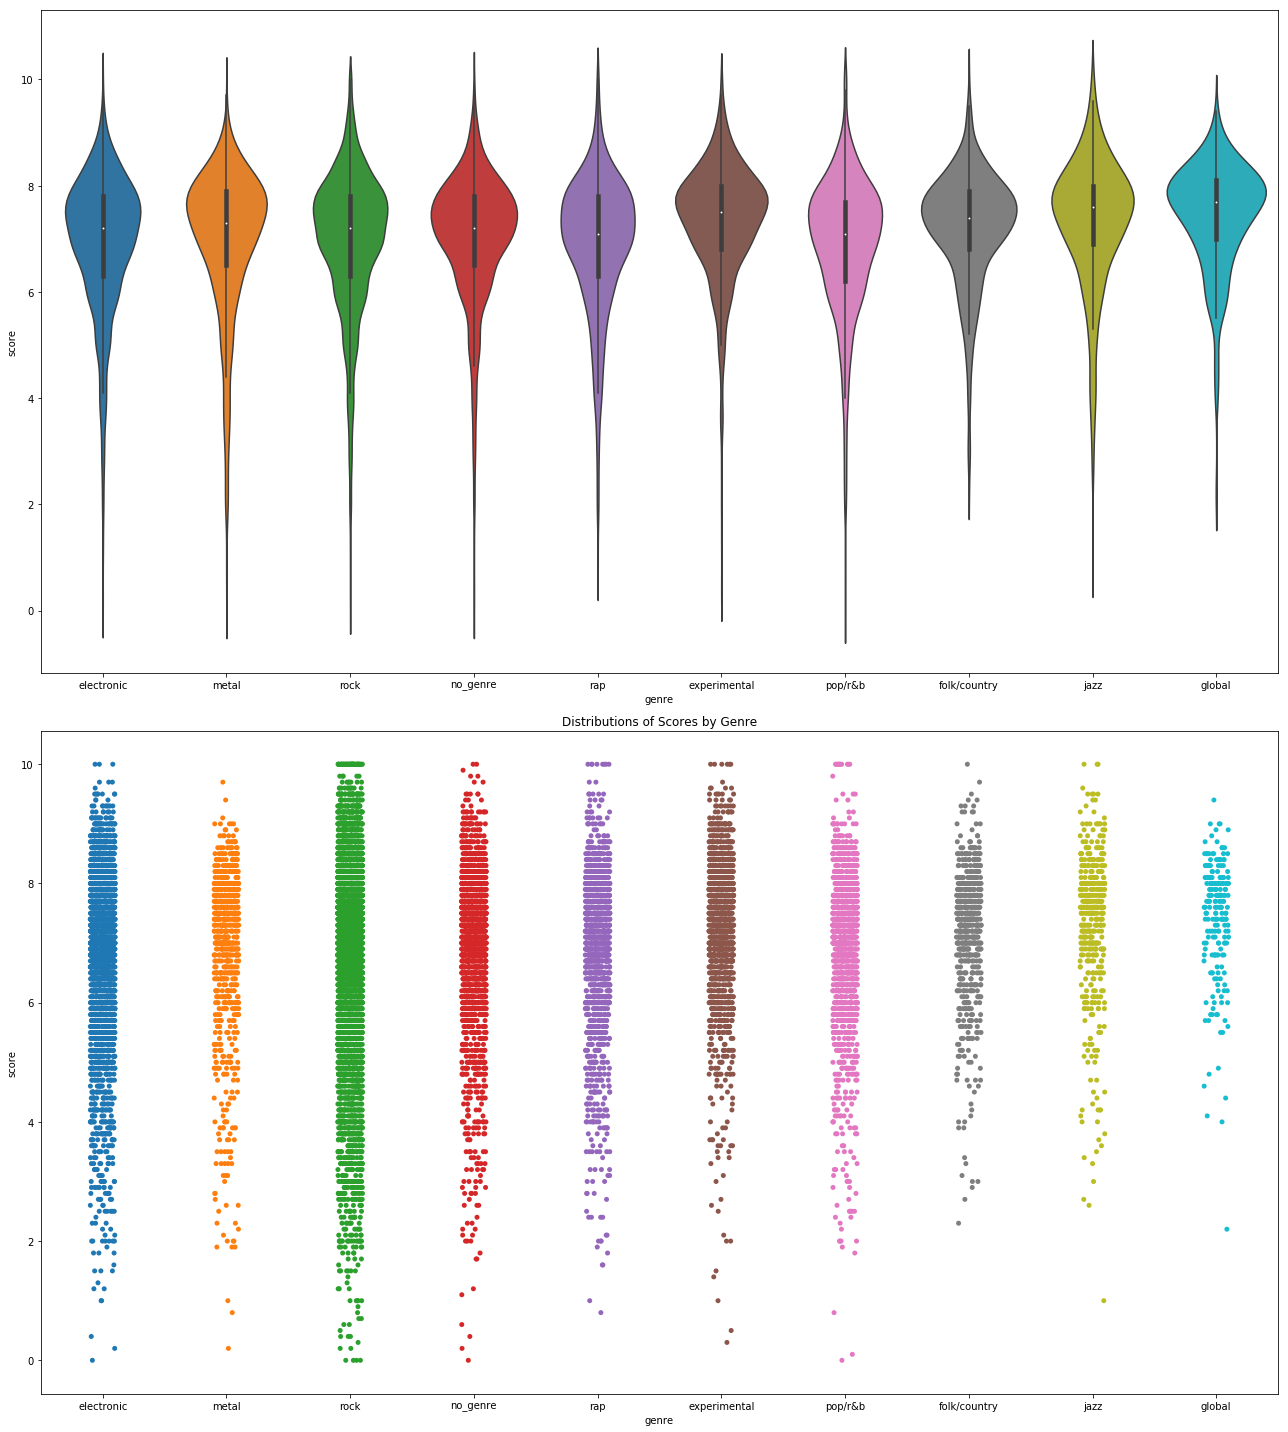

In [18]:
# Visualize distributions of scores by genre

f, axes = plt.subplots(2, 1, figsize = (18, 20))
plt.title("Distributions of Scores by Genre")
sns.violinplot(x="genre", y="score", data=df_genre_scores, ax = axes[0])
sns.stripplot(x="genre", y="score", data=df_genre_scores, ax = axes[1])
plt.tight_layout()

Notice that the mean values and kernel densities look similar across the genres.

## Question 1: Is there a statistical difference between the scores of folk/country and metal genres?

Null hypothesis: There is no difference between the mean score of folk/country and metal genres. <br>
Alternative Hypothesis: There is a difference between the mean score of folk/country and metal genres.

In [19]:
# Create dataframe for folk/country and scores
is_folk = df_genre_scores['genre']== 'folk/country'
folk_scores = df_genre_scores.loc[is_folk]
folk_scores.head()

,score,genre
28,6.8,folk/country
78,7.8,folk/country
127,7.3,folk/country
147,8.5,folk/country
152,7.8,folk/country


In [20]:
folk_scores.describe()

,score
count,685.000000
mean,7.202190
std,1.064435
min,2.300000
25%,6.800000
50%,7.400000
75%,7.900000
max,10.000000


In [21]:
# Create dataframe for metal and scores
is_metal = df_genre_scores['genre']== 'metal'
metal_scores = df_genre_scores.loc[is_metal]
metal_scores.head()

,score,genre
1,7.9,metal
22,7.5,metal
33,7.7,metal
124,6.5,metal
146,6.4,metal


In [22]:
metal_scores.describe()

,score
count,862.000000
mean,6.950000
std,1.387799
min,0.200000
25%,6.500000
50%,7.300000
75%,7.900000
max,9.700000


Test Null Hypothesis. Assume p-value < 0.05 to reject null hypothesis. The standard deviations are different, thus the variances are different, so we'll set "equal_var=False" to use Welch's test.

In [23]:
ttest_ind(folk_scores['score'], metal_scores['score'], axis=0, equal_var=False)

Ttest_indResult(statistic=4.044303101957469, pvalue=5.507059645103283e-05)

From the t-test, the p-value for this relationship is much higher than .05. We fail to reject the null hypothesis. There is no significant difference between average scores for folk/country and metal music.

In [24]:
# Initialize parameters
effect = 0.8
alpha = 0.05
power = 0.8
# Size of folk/country scores sample to all other music sample
ratio = len(metal_scores) / len(folk_scores)
print(ratio)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                              ratio=ratio, alpha=alpha)
print(f"Minimum Sample Size: {result}")
print(f"Folk/Country Sample Size: {len(folk_scores)}")

1.2583941605839417
Minimum Sample Size: 22.891880051492222
Folk/Country Sample Size: 685


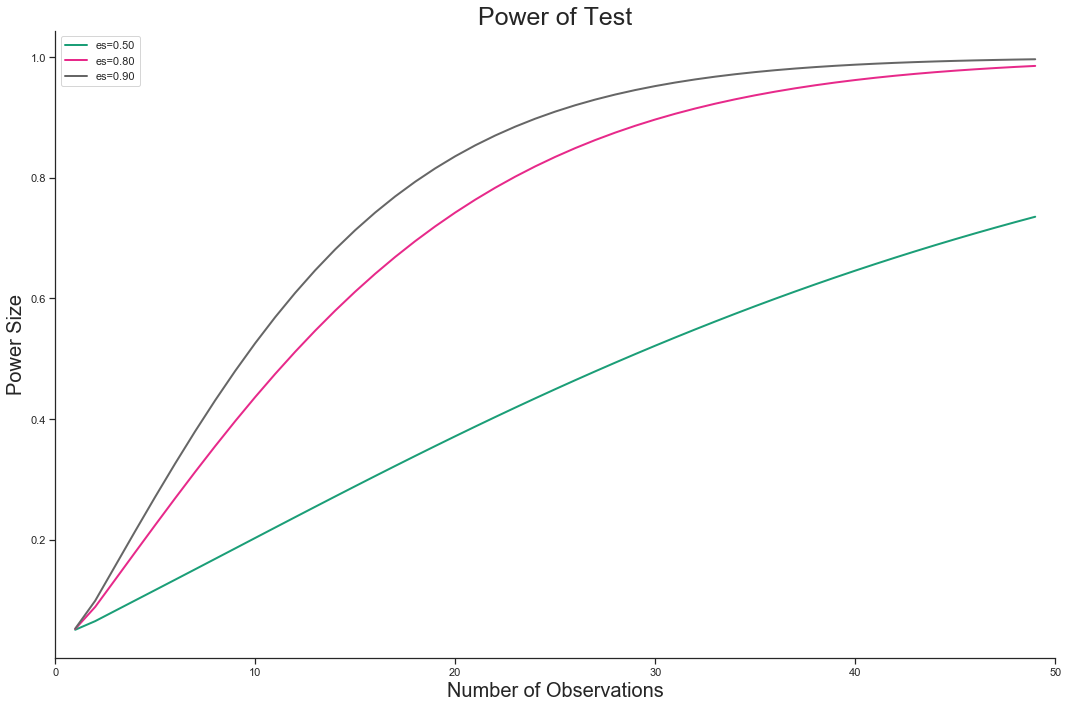

In [25]:
# parameters for power analysis
effect_sizes = np.array([0.5, 0.8, 0.9])
sample_sizes = np.array(range(1, 50))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, ratio=ratio, effect_size=effect_sizes)
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 50)
plt.ylabel('Power Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

Based on the power analysis, we can accept results of the hypothesis test.

## Question 2: Is there a difference between the ratings of folk/country music and all other music?

Check unique list of genres. Include value counts.

In [26]:
query_unique_genres = """ SELECT genre, COUNT(genres)
FROM genres
GROUP BY genre;"""

In [27]:
cur.execute(query_unique_genres)

In [28]:
cur.fetchall()

[('global', 217),
 ('experimental', 1815),
 ('metal', 860),
 (None, 2367),
 ('electronic', 3874),
 ('folk/country', 685),
 ('pop/r&b', 1432),
 ('jazz', 435),
 ('rap', 1559),
 ('rock', 9436)]

Going with 'folk/country.' Reviews seem to be rated by 'score' and 'best new music.' Look at descriptive statistics and variances. Make distributions of 'folk/country' and all other music. 

In [29]:
og_df = df_genre_scores[df_genre_scores['genre'] != 'folk/country'].copy()

In [30]:
og_df.describe()

,score
count,22005.000000
mean,6.984585
std,1.311801
min,0.000000
25%,6.400000
50%,7.200000
75%,7.800000
max,10.000000


In [31]:
fc_var = np.var(folk_scores, ddof=1)
og_var = np.var(og_df, ddof=1)
fc_var[0], og_var[0]

(1.1330215136381099, 1.7208230931221074)

The variances are unequal and sizes unequal, do Welch's T-test.

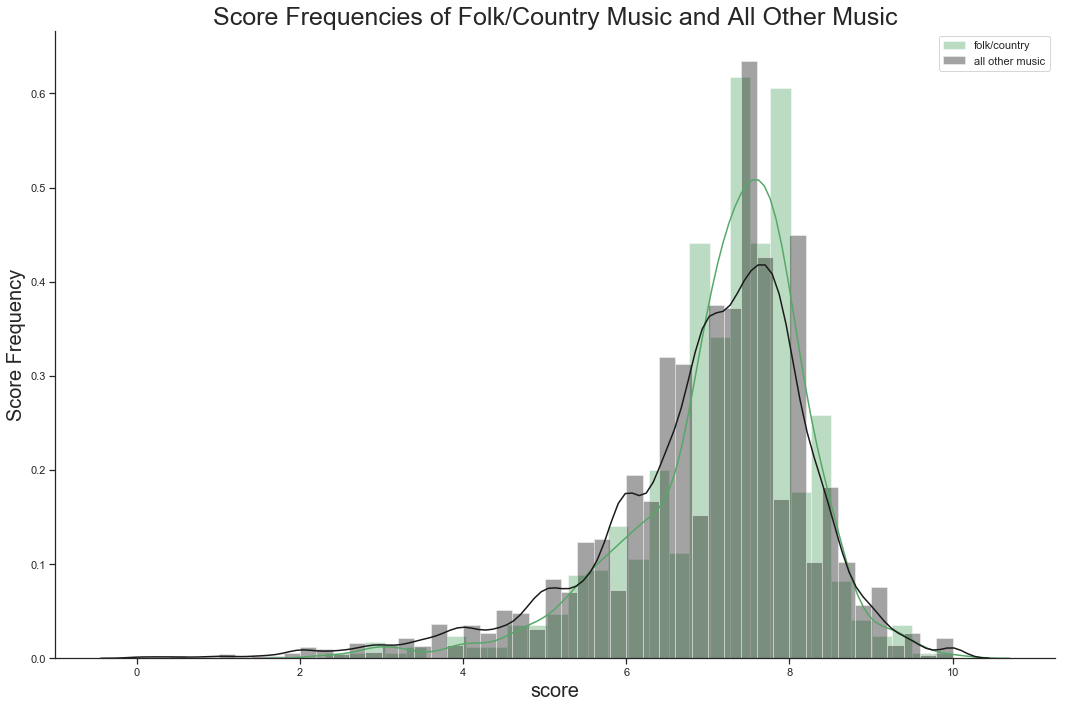

In [32]:
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Score Frequency', fontsize='20')
plt.title('Score Frequencies of Folk/Country Music and All Other Music', fontsize='25')
sns.distplot(folk_scores['score'], color='g', label='folk/country')
sns.distplot(og_df['score'], color='k', label='all other music')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

From a visual, it looks like there is little, if any, difference between folk/country ratings and all other music. To determine whether folk/country ratings or all other music ratings we use a Welch's T-Test to compare the average ratings for each sample. We also conduct a power analysis. By convention, significance level (alpha) is 0.05, effect size (Cohen's d measure) is at least 0.8, and statistical power is 0.8. Our hypotheses are: <br>
Null Hypothesis: The mean difference between review score for folk/country and all other music is zero. <br>
Alternative Hypothesis: The mean difference between review score folk/country and all other music is different from zero. <br>

In [33]:
# Use scipy.stats to conduct 2-sample t-test
ttest_ind(folk_scores['score'], og_df['score'], equal_var=False )

Ttest_indResult(statistic=5.228327988171828, pvalue=2.2201136243634723e-07)

The p-value is ~ 2.22, which is greater than 0.05. Not enough evidence to reject null hypothesis. There is no statistical difference in the average review scores between folk/country and all other music. <br> <br>
Next, do a power analysis to estimate a suitable sample size (how many observations needed for each sample) to detect an effect of 0.8 with an 80% chance of detecting the effect if it is true (so 20% false negatives) and a 5% chance of detecting an effect if there is no effect (false positives). 

In [34]:
# Initialize parameters
effect = 0.8
alpha = 0.05
power = 0.8
# Size of folk/country scores sample to all other music sample
ratio = len(folk_scores) / len(og_df)  
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"Minimum Sample Size: {result}")
print(f"Folk/Country Sample Size:{len(folk_scores)}")

Minimum Sample Size: 408.09978349002654
Folk/Country Sample Size:685


The sample size of folk country is greater than the estimated sample size needed. Generate power curves, to visualize how effect changes with different sample sizes.

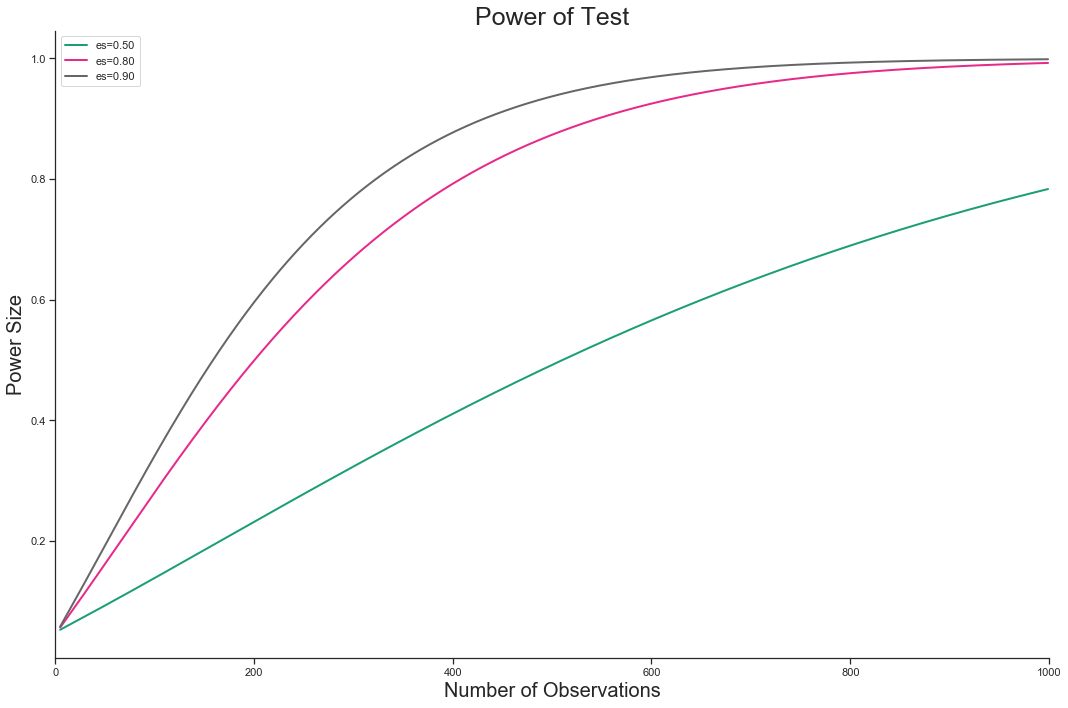

In [57]:
# parameters for power analysis
effect_sizes = np.array([0.5, 0.8, 0.9])
sample_sizes = np.array(range(5, 1000))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, ratio=ratio, effect_size=effect_sizes, plt_kwds={'colors':'k'})
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 1000)
plt.ylabel('Power Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

Based on the power analysis we can accept the hypothesis results.

## Question 4: Is there a difference between the average scores given by each author for folk/country music?

Select the number of reviews and average scores given by authors for folk/country music and put into a dataframe.

In [42]:
query_authors = """ SELECT reviews.author
, COUNT(reviews.author)
, AVG(reviews.score)
FROM reviews
JOIN genres ON reviews.reviewid = genres.reviewid
WHERE genre = 'folk/country'
GROUP BY
reviews.author
ORDER BY
COUNT(reviews.author) DESC
;"""

In [43]:
cur.execute(query_authors)

In [44]:
cur.fetchmany(5)

[('stephen m. deusner', 102, 7.27058821565965),
 ('matthew murphy', 40, 7.21999999284744),
 ('joe tangari', 37, 7.41081084431829),
 ('amanda petrusich', 31, 7.5645161444141),
 ('grayson currin', 24, 7.4125000834465)]

In [46]:
authors_df = pd.read_sql(query_authors, conn)

In [47]:
authors_df.head()

,author,count,avg
0,stephen m. deusner,102,7.270588
1,matthew murphy,40,7.220000
2,joe tangari,37,7.410811
3,amanda petrusich,31,7.564516
4,grayson currin,24,7.412500


In [98]:
authors_df.describe()

,count,avg
count,130.000000,130.000000
mean,5.269231,7.097459
std,10.675472,0.966489
min,1.000000,2.700000
25%,1.000000,6.708333
50%,2.000000,7.200000
75%,5.000000,7.696428
max,102.000000,10.000000


Visualize distributions of count, average score, and relationship between average score and count.

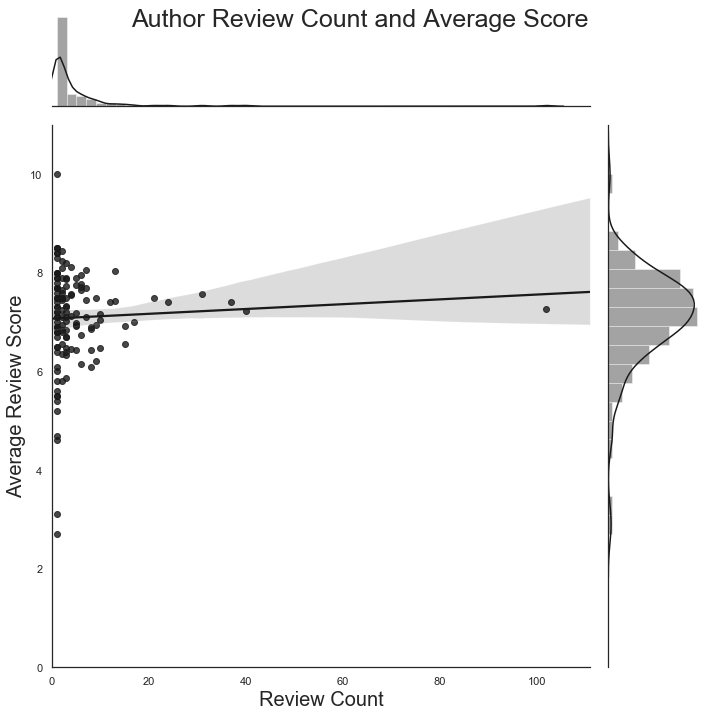

In [130]:
sns.set()
sns.set_style("white")
sns.jointplot(authors_df['count'], authors_df['avg'], height=10, kind='reg', color='k')
plt.xlabel('Review Count', fontsize='20')
plt.ylabel('Average Review Score', fontsize='20')
plt.suptitle('Author Review Count and Average Score', fontsize='25')
plt.xlim(0)
plt.ylim(0, 11);

Perhaps authors often review music in many genres. We query for authors, number of reviews, and average review score across all genres, and visualize.

In [133]:
query_all_authors = """ SELECT reviews.author
, COUNT(reviews.author)
, AVG(reviews.score)
FROM reviews
JOIN genres ON reviews.reviewid = genres.reviewid
GROUP BY
reviews.author
ORDER BY
COUNT(reviews.author) DESC
;"""

In [134]:
all_authors_df = pd.read_sql(query_all_authors, conn)

In [135]:
all_authors_df.describe()

,count,avg
count,432.000000,432.000000
mean,52.523148,7.014440
std,115.918703,0.920195
min,1.000000,1.700000
25%,2.000000,6.633333
50%,11.000000,7.072736
75%,42.500000,7.400000
max,987.000000,10.000000


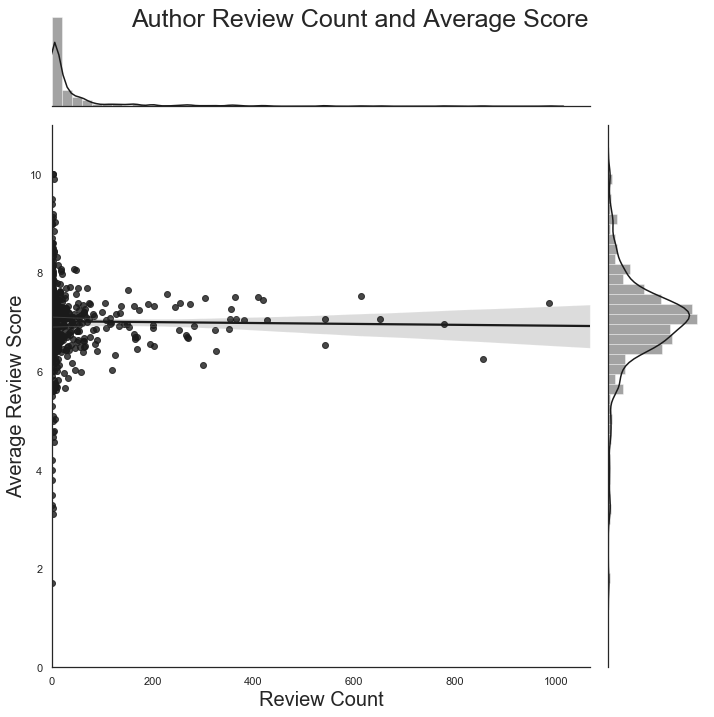

In [136]:
sns.set()
sns.set_style("white")
sns.jointplot(all_authors_df['count'], all_authors_df['avg'], height=10, kind='reg', color='k')
plt.xlabel('Review Count', fontsize='20')
plt.ylabel('Average Review Score', fontsize='20')
plt.suptitle('Author Review Count and Average Score', fontsize='25')
plt.xlim(0)
plt.ylim(0, 11);

There are many authors who have made fewer review scores and the average review score seems to follow a normal distribution for within the folk/country genre and across all genres. The relationship between review count and average review score appears to be uniform, however we cannot do an ANOVA when the number of reviews is different for each author. To test if there is a difference between the average review score of authors we use a Kruskal-Wallis H Test, which accounts for size variation by looking at the median instead of the mean. We drop any authors with less than 5 reviews because the Kruskal-Wallis H-Test is based on a Chi-squared distribution and needs a sample size of at least 5. We test within folk/country genre and across all genres. <br> <br>
Null Hypothesis: There is no difference between the average review score <br>
Alternative Hypothesis: There is a difference between average review scores <br> <br>
To conduct Kruskal-Wallis H-Test, need to query dataframe for all review scores for all authors with more than 5 reviews.

In [230]:
query_more5 = """ SELECT author
, score
FROM reviews
WHERE author IN (SELECT author FROM reviews GROUP BY author HAVING COUNT(*) > 5)
GROUP BY 
author
, score
ORDER BY
author ASC;"""

In [265]:
more5_df = pd.read_sql(query_more5, conn)

In [270]:
more5_df.head()

,author,score
0,aaron leitko,6.8
1,aaron leitko,3.9
2,aaron leitko,5.8
3,aaron leitko,7.9
4,aaron leitko,6.3


In [300]:
more5_df.shape

(5891, 2)

In [301]:
more5pivot = more5_df.pivot(columns='author').copy()

In [305]:
args = [more5pivot[col].values for col in more5pivot.columns]

In [306]:
H, pval = mstats.kruskalwallis(args)

In [307]:
H, pval

(510.7726472013318, 1.0021474794983724e-19)

## Question 5: Is there a difference between the average scores of folk/country music for each label?